In [1]:
import meteostat
import pandas as pd
from pyncei import NCEIBot
import matplotlib.pyplot as plt
import time
import requests

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

from lib import data_loaders

import os
from dotenv import load_dotenv, dotenv_values

# loading variables from .env file
load_dotenv()

# os.getenv("NCEI_KEY")
ncei = NCEIBot(os.getenv("NCEI_KEY"))

In [35]:
dp_poly = gpd.read_file("./gis/tnc.geojson")
# dangermond is in utm zone 10n, i.e. EPSG:32610
dp_poly = dp_poly.to_crs(epsg="32610")
# create buffer
dp_buffer = dp_poly.geometry.buffer(30000)  # 30km
# make smaller buffer for IEM stations
dp_buffer_15km = dp_poly.geometry.buffer(15000)  # 15km

In [3]:
inventory_df = pd.read_table(
    "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt",
    sep="\s+",
    names=["id", "lat", "lon", "var", "start", "end"],
)

In [4]:
# need data from 1979-2023

# start by fetching inventory data from NCEI GHCNd
# cols described here: https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily
inventory_df = pd.read_table(
    "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt",
    sep="\s+",
    names=["id", "lat", "lon", "var", "start", "end"],
)

# also download "stations" directory, in order to add station names to the inventory
ncei_stations = pd.read_fwf(
    "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt",
    header=None,
    sep="\s+",
)

# station name cols, which are not parsed correctly by pandas (combine 4,5)
ncei_stations["station_name_full"] = (
    ncei_stations[ncei_stations[4].notna()][4]
    + ncei_stations[ncei_stations[5].notna()][5]
)

# collapse back to single col
ncei_stations["station_name_full"] = ncei_stations["station_name_full"].fillna(
    ncei_stations[4]
)
ncei_stations = ncei_stations.drop([4, 5], axis=1)
ncei_stations.columns = [
    "id",
    "lat",
    "lon",
    "elev",
    "network",
    "num",
    "station_name_full",
]

# combine on id
# inventory_df = pd.concat([inventory_df, ncei_stations], keys='id')

In [5]:
# create GeoDataFrame
geometry = [Point(xy) for xy in zip(inventory_df.lon, inventory_df.lat)]
df = inventory_df.drop(["lon", "lat"], axis=1)
gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

# dangermond is in utm zone 10n, i.e. EPSG:32610
gdf = gdf.to_crs(epsg="32610")

In [6]:
mask = gdf.within(dp_buffer.iloc[0])
gdf_near = gdf.loc[mask]

In [7]:
gdf_near

,id,var,start,end,geometry
199663,US1CASB0002,PRCP,2009,2011,POINT (756379.474 3834715.257)
199664,US1CASB0002,SNOW,2009,2011,POINT (756379.474 3834715.257)
199669,US1CASB0007,PRCP,2014,2024,POINT (756837.250 3834095.146)
199670,US1CASB0007,SNOW,2014,2024,POINT (756837.250 3834095.146)
199671,US1CASB0007,SNWD,2023,2023,POINT (756837.250 3834095.146)
...,...,...,...,...,...
737888,USW00093221,WDFG,1969,1969,POINT (717076.536 3829379.837)
737889,USW00093221,WSFG,1969,1969,POINT (717076.536 3829379.837)
737890,USW00093221,WT01,1969,1969,POINT (717076.536 3829379.837)
737891,USW00093221,WT08,1969,1969,POINT (717076.536 3829379.837)


<Axes: >

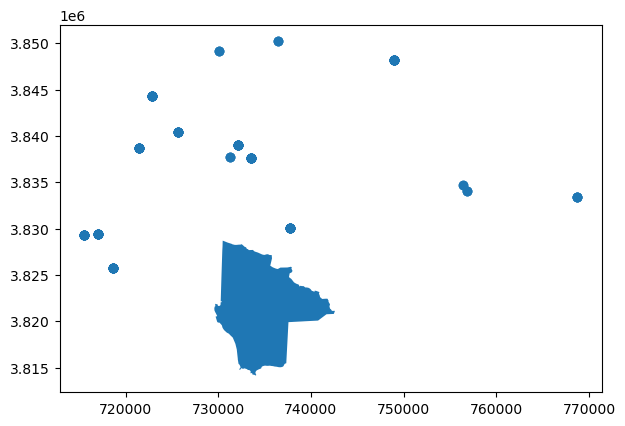

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))

gdf_near.plot(ax=ax)
dp_poly.plot(ax=ax)

In [15]:
gdf_near["id"].unique()

array(['US1CASB0002', 'US1CASB0007', 'US1CASB0020', 'USC00043787',
       'USC00045064', 'USC00045107', 'USC00047016', 'USC00047681',
       'USC00047976', 'USC00048697', 'USR0000CVND', 'USW00023243',
       'USW00093214', 'USW00093215', 'USW00093219', 'USW00093221'],
      dtype=object)

In [16]:
# check period of record for nearby sites before collecting:
for site in gdf_near["id"].unique():
    print(site)
    start = inventory_df[inventory_df.id == site]["start"].min()
    end = inventory_df[inventory_df.id == site]["end"].max()

    # if end > 1978: # only want data during study period
    print(f"start: {start}, end: {end}")

    print("---")

US1CASB0002
start: 2009, end: 2011
---
US1CASB0007
start: 2014, end: 2024
---
US1CASB0020
start: 2018, end: 2020
---
USC00043787
start: 1948, end: 1964
---
USC00045064
start: 1917, end: 2024
---
USC00045107
start: 1894, end: 2008
---
USC00047016
start: 1948, end: 1979
---
USC00047681
start: 1948, end: 2024
---
USC00047976
start: 1948, end: 1951
---
USC00048697
start: 1906, end: 1951
---
USR0000CVND
start: 2002, end: 2023
---
USW00023243
start: 2016, end: 2024
---
USW00093214
start: 1951, end: 1970
---
USW00093215
start: 1959, end: 1965
---
USW00093219
start: 1966, end: 1969
---
USW00093221
start: 1969, end: 1969
---


In [ ]:
ghcnd_data = {}

# get data for nearby stations
for site in gdf_near["id"].unique():
    print(site)
    start = inventory_df[inventory_df.id == site]["start"].min()
    end = inventory_df[inventory_df.id == site]["end"].max()

    if end > 1978:  # only want stations with data during study period

        print(f"start: {start}, end: {end}")

        if start < 1978:  # don't request years before start of site
            start = 1978

        years = []

        for year in range(start - 1, end + 1):
            print(f"requesting data for {site}")
            print(year)
            # NCEI data access for all networks
            response = ncei.get_data(
                datasetid="GHCND",
                stationid=[f"GHCND:{site}"],
                # datatypeid=["TMIN", "TMAX"], # all for now
                startdate=f"{year}-01-01",
                enddate=f"{year}-12-31",
            )

            df_year = response.to_dataframe()

            if not df_year.empty:
                years.append(df_year)

            time.sleep(6)  # slow down requests a bit

        df_site = pd.concat(years)
        ghcnd_data[site] = df_site

    print("---")

In [ ]:
ghcnd_data.keys()

In [ ]:
for stn in ghcnd_data.keys():
    df = ghcnd_data[stn]
    start = df["date"].min().strftime("%Y%m%d")
    end = df["date"].max().strftime("%Y%m%d")
    # df.to_parquet(f"./output/{stn}_{start}_{end}.parquet")

In [36]:
# Get HADS data from Iowa Environmental Mesonet
df_ca_awos = pd.read_csv(
    "https://mesonet.agron.iastate.edu/sites/networks.php?network=CA_ASOS&format=csv&nohtml=on"
)
df_ca_coop = pd.read_csv(
    "https://mesonet.agron.iastate.edu/sites/networks.php?network=CA_COOP&format=csv&nohtml=on"
)
df_ca_dcp = pd.read_csv(
    "https://mesonet.agron.iastate.edu/sites/networks.php?network=CA_DCP&format=csv&nohtml=on"
)

ca_iem = pd.concat([df_ca_awos, df_ca_coop, df_ca_dcp])

# create GeoDataFrame
geometry = [Point(xy) for xy in zip(ca_iem.lon, ca_iem.lat)]
df = ca_iem.drop(["lon", "lat"], axis=1)
iem_gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

# dangermond is in utm zone 10n, i.e. EPSG:32610
iem_gdf = iem_gdf.to_crs(epsg="32610")

# use smaller 5km buffer for IEM stations
iem_mask = iem_gdf.within(dp_buffer_15km.iloc[0])
iem_gdf_near = iem_gdf.loc[iem_mask]

<Axes: >

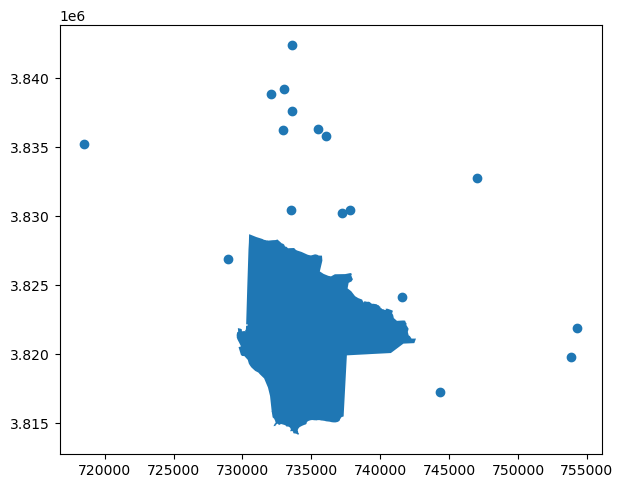

In [37]:
fig, ax = plt.subplots(figsize=(7, 7))

iem_gdf_near.plot(ax=ax)
dp_poly.plot(ax=ax)

In [38]:
iem_gdf_near

,stid,station_name,elev,begints,endts,iem_network,geometry
60,LPC,LOMPOC (AWOS),27.000000,1992-04-09 00:00,NaN,CA_ASOS,POINT (732057.857 3838880.782)
151,TQS,Vandenberg Space Force South,92.000000,2024-02-29 00:00,NaN,CA_ASOS,POINT (718518.022 3835264.914)
164,LOMC1,Lompoc,28.840906,2011-12-09 00:00,NaN,CA_COOP,POINT (733575.833 3837607.073)
266,SASC1,Salsipuedes Gaging Station,153.000000,2012-07-01 00:00,NaN,CA_COOP,POINT (737205.498 3830206.971)
486,LCUC1,Buellton - Las Cruces,126.286156,2013-09-25 00:00,NaN,CA_DCP,POINT (754307.977 3821913.071)
488,STJC1,Buellton - Santa Rosa Park,114.425000,2013-09-24 00:00,NaN,CA_DCP,POINT (747052.730 3832751.544)
506,BMFC1,Burton Mesa Fire Station,102.831620,2011-09-26 00:00,NaN,CA_DCP,POINT (733572.173 3842457.701)
686,CELC1,CELITE #586,263.000000,2010-12-07 00:00,NaN,CA_DCP,POINT (733545.504 3830457.949)
1280,HOTC1,Gaviota - Hollister No70,41.948350,2013-10-01 00:00,NaN,CA_DCP,POINT (744304.201 3817226.194)
1281,GVTC1,Gaviota RAWS,237.106770,2018-04-10 00:00,NaN,CA_DCP,POINT (753830.740 3819771.813)


In [39]:
iem_data = {}

for row, values in iem_gdf_near.iterrows():
    network = values["iem_network"]
    siteid = values["stid"]

    years = []
    for year in range(1979, 2024):
        print(f"requesting {siteid}, {year}")
        df = data_loaders.request_HADS(
            year=year, siteid=siteid, network=network)
        years.append(df)

    # only concat and append if there is a df returned (else None)
    if any(isinstance(i, pd.DataFrame) for i in years):
        df = pd.concat(years)
        iem_data[siteid] = df

    else:
        print(f"no data returned for {siteid}")

requesting LPC, 1979
Error: 'utc_valid'
requesting LPC, 1980
Error: 'utc_valid'
requesting LPC, 1981
Error: 'utc_valid'
requesting LPC, 1982
Error: 'utc_valid'
requesting LPC, 1983
Error: 'utc_valid'
requesting LPC, 1984
Error: 'utc_valid'
requesting LPC, 1985
Error: 'utc_valid'
requesting LPC, 1986
Error: 'utc_valid'
requesting LPC, 1987
Error: 'utc_valid'
requesting LPC, 1988
Error: 'utc_valid'
requesting LPC, 1989
Error: 'utc_valid'
requesting LPC, 1990
Error: 'utc_valid'
requesting LPC, 1991
Error: 'utc_valid'
requesting LPC, 1992
Error: 'utc_valid'
requesting LPC, 1993
Error: 'utc_valid'
requesting LPC, 1994
Error: 'utc_valid'
requesting LPC, 1995
Error: 'utc_valid'
requesting LPC, 1996
Error: 'utc_valid'
requesting LPC, 1997
Error: 'utc_valid'
requesting LPC, 1998
Error: 'utc_valid'
requesting LPC, 1999
Error: 'utc_valid'
requesting LPC, 2000
Error: 'utc_valid'
requesting LPC, 2001
Error: 'utc_valid'
requesting LPC, 2002
Error: 'utc_valid'
requesting LPC, 2003
Error: 'utc_valid'


In [53]:
for site, df in iem_data.items():
    start = df.index.min().strftime("%Y%m%d")
    end = df.index.max().strftime("%Y%m%d")
    # print(df.to_parquet(f"./output/{site}_{start}_{end}.parquet"))